In [2]:
!nvidia-smi

Mon Nov 29 20:43:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.77       Driver Version: 466.77       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P8    N/A /  N/A |     64MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install tensorflow-gpu


  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
feature-engine 1.1.0 requires statsmodels>=0.11.1, which is not installed.
tensorflow 2.3.0 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow 2.3.0 requires h5py<2.11.0,>=2.10.0, but you have h5py 3.1.0 which is incompatible.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.5 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you have scipy 1.7.1 which is incompatible.
tensorflow 2.3.0 requires tensorflow-estimator<2.4.0,>=2.3.0, but you have tensorflow-estimator 2.6.0 which is incompatible.



  Using cached numpy-1.19.5-cp38-cp38-win_amd64.whl (13.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.3
    Uninstalling numpy-1.21.3:
      Successfully uninstalled numpy-1.21.3
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2


In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.layers import Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential,load_model
import numpy as np
from glob import glob
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Import the INception v3 library as shown below and add preprocessing layer to the front of VGG
# Here we will be using imagenet weights

IMAGE_SIZE = [224,224]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

In [7]:
# dont train exixting weights
for layer in inception.layers:
  layer.trainable = False

In [8]:
# useful for getting number of output classes
folders = glob('D:\Plant_Disease_Dataset\Maize\\train\*')
folders

['D:\\Plant_Disease_Dataset\\Maize\\train\\Blight',
 'D:\\Plant_Disease_Dataset\\Maize\\train\\Common_Rust',
 'D:\\Plant_Disease_Dataset\\Maize\\train\\Gray_Leaf_Spot',
 'D:\\Plant_Disease_Dataset\\Maize\\train\\Healthy']

In [9]:
# Our layers - we can add more if we want to.
x = Flatten()(inception.output)

In [10]:
prediction = Dense(len(folders),activation='softmax')(x)

In [11]:
model = Model(inputs=inception.input, outputs=prediction)

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
# telling the model what cost and optimisation method to use
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
# # Use the Data generator to import from the dataset
# from tensorflow.keras.preprocessing.image import ImageDataGenerator


batch_size = 32
img_height = 224
img_width = 224

dir1 = 'D:\Plant_Disease_Dataset\Maize\\train'
dir2 = 'D:\Plant_Disease_Dataset\Maize\\test'

data_dir = pathlib.Path(dir1)
test_dir = pathlib.Path(dir2)

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy'], dtype='<U14')

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_gen_train = ImageDataGenerator(rescale = 1./255,
                                     validation_split=0.2,
                                     rotation_range = 45,
                                     width_shift_range=.15,
                                     height_shift_range =.15,
                                     horizontal_flip=True,
                                     zoom_range=0.5)

In [16]:


train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                              subset = 'training',  
                                              directory= data_dir,       
                                              shuffle=True,
                                              target_size=(img_height, img_width)
                                              )    

validation_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                              subset = 'validation',  
                                              directory= data_dir,       
                                              shuffle=True,
                                              target_size=(img_height, img_width)
                                              )  

Found 3275 images belonging to 4 classes.
Found 817 images belonging to 4 classes.


In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
rlr = ReduceLROnPlateau(patience=10, verbose=1)
es = EarlyStopping(patience=24, restore_best_weights=True, verbose=1)
mc = ModelCheckpoint('model_inceptionv3.hdf5', save_best_only=True, verbose=1)

In [18]:


epochs = 30
history = model.fit(
  train_data_gen,
  callbacks=[rlr, es, mc],  
  validation_data=validation_data_gen,
  epochs=epochs
)

Epoch 1/30
103/103 [==============================] - 297s 3s/step - loss: 2.4665 - accuracy: 0.7566 - val_loss: 1.4811 - val_accuracy: 0.8115

Epoch 00001: val_loss improved from inf to 1.48114, saving model to model_inceptionv3.hdf5
Epoch 2/30
103/103 [==============================] - 241s 2s/step - loss: 1.2595 - accuracy: 0.8382 - val_loss: 1.0098 - val_accuracy: 0.8617

Epoch 00002: val_loss improved from 1.48114 to 1.00977, saving model to model_inceptionv3.hdf5
Epoch 3/30
103/103 [==============================] - 232s 2s/step - loss: 1.1432 - accuracy: 0.8598 - val_loss: 1.4036 - val_accuracy: 0.8311

Epoch 00003: val_loss did not improve from 1.00977
Epoch 4/30
103/103 [==============================] - 231s 2s/step - loss: 1.1222 - accuracy: 0.8696 - val_loss: 1.4975 - val_accuracy: 0.8690

Epoch 00004: val_loss did not improve from 1.00977
Epoch 5/30
103/103 [==============================] - 242s 2s/step - loss: 1.3128 - accuracy: 0.8653 - val_loss: 2.2653 - val_accuracy: 

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib

dir1='/content/drive/MyDrive/Plant_Disease_Dataset/Plant_Disease_Dataset/Maize//Test'

image_gen_test = ImageDataGenerator(rescale = 1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=32,
                                              directory= test_dir,
                                              shuffle=False,
                                              target_size=(img_height, img_width)
                                              )  

Found 96 images belonging to 4 classes.


In [21]:
model_demo2=load_model('model_inceptionv3.hdf5')

In [22]:
model_demo2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [23]:
predictions1 = model_demo2.predict(test_data_gen)

In [24]:
for i in range(0,96):
  score = tf.nn.softmax(predictions1[i])

  print(i+1,')',
    "This image most likely belongs to {} with a {:.2f} percent probability."
    .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score))
  )

1 ) This image most likely belongs to Blight with a 47.54 percent probability.
2 ) This image most likely belongs to Blight with a 47.54 percent probability.
3 ) This image most likely belongs to Blight with a 47.54 percent probability.
4 ) This image most likely belongs to Gray_Leaf_Spot with a 47.54 percent probability.
5 ) This image most likely belongs to Common_Rust with a 45.45 percent probability.
6 ) This image most likely belongs to Blight with a 41.29 percent probability.
7 ) This image most likely belongs to Blight with a 47.54 percent probability.
8 ) This image most likely belongs to Gray_Leaf_Spot with a 47.43 percent probability.
9 ) This image most likely belongs to Blight with a 47.54 percent probability.
10 ) This image most likely belongs to Gray_Leaf_Spot with a 47.54 percent probability.
11 ) This image most likely belongs to Blight with a 47.54 percent probability.
12 ) This image most likely belongs to Blight with a 33.35 percent probability.
13 ) This image most

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
plot_gen_input = ImageDataGenerator(rescale = 1./255)
plot_data_gen_input = image_gen_test.flow_from_directory(batch_size=96,
                                              directory= test_dir,
                                              shuffle=False,
                                              target_size=(img_height, img_width)
                                              )  

Found 96 images belonging to 4 classes.


In [26]:
def show_batch_input(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(96):
        ax = plt.subplot(10,10,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
        plt.axis('off')


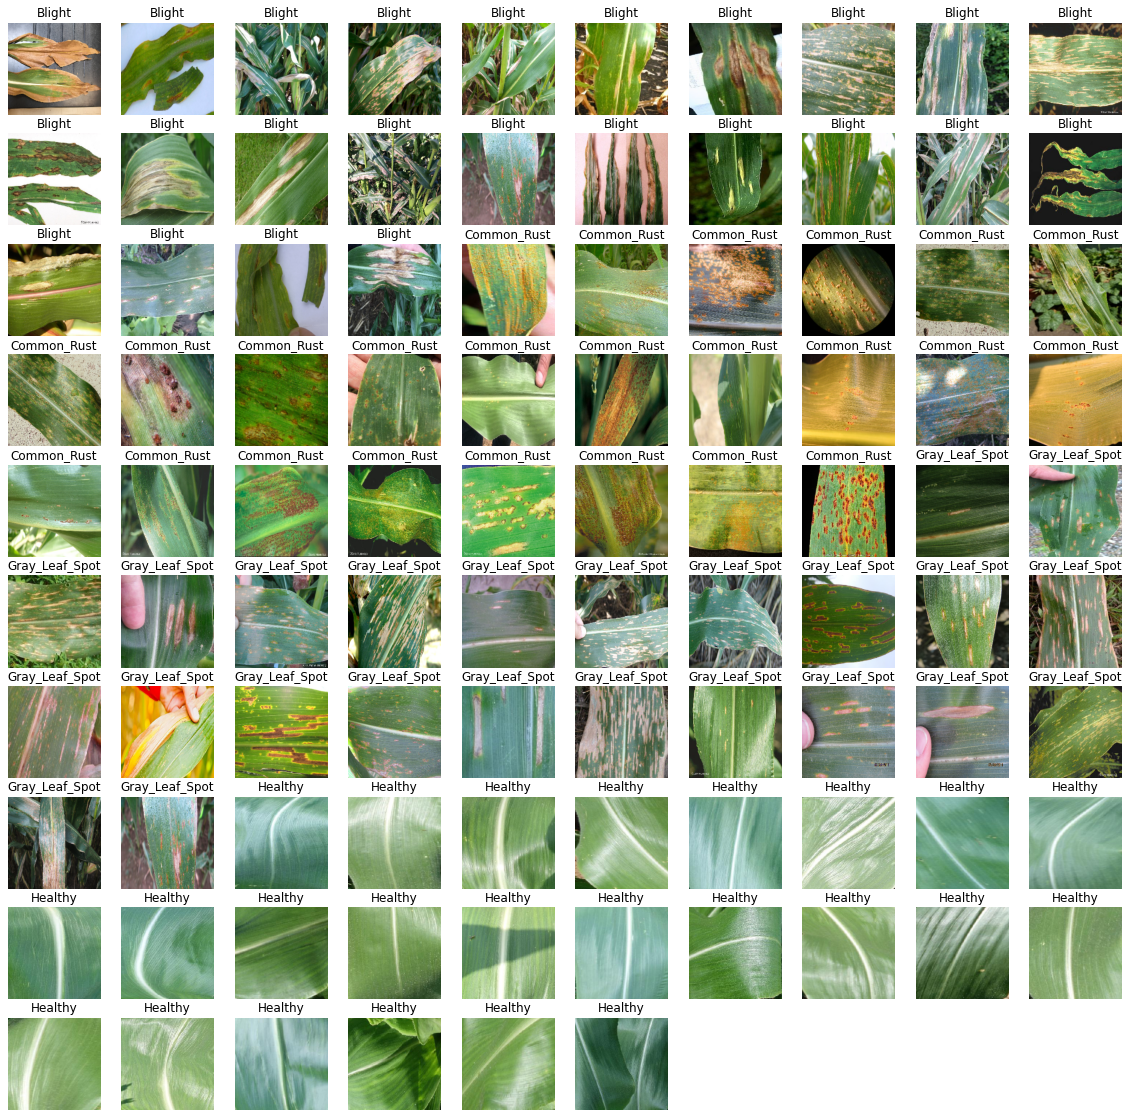

In [27]:
image_batch_input, label_batch_input = next(plot_data_gen_input)
show_batch_input(image_batch_input, label_batch_input)

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
plot_gen_output = ImageDataGenerator(rescale = 1./255)
plot_data_gen_output = image_gen_test.flow_from_directory(batch_size=96,
                                              directory= test_dir,
                                              shuffle=False,
                                              target_size=(img_height, img_width)
                                              )  

Found 96 images belonging to 4 classes.


In [29]:
def show_batch_output(image_batch, label_batch):
    plt.figure(figsize=(20,20))
    for n in range(96):
        score = tf.nn.softmax(predictions1[n])
        ax = plt.subplot(10,10,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[np.argmax(score)])
        plt.axis('off')


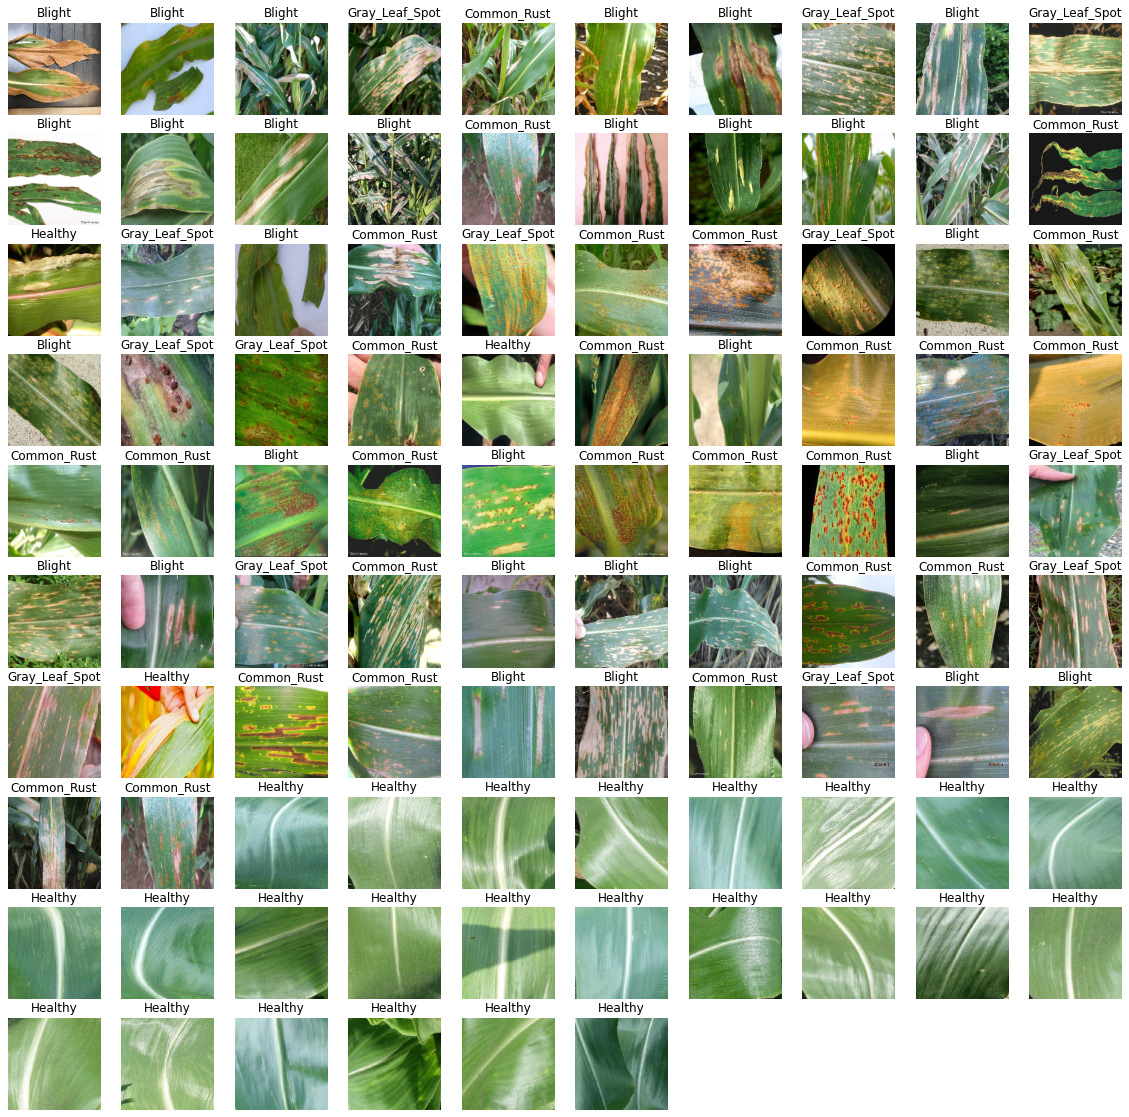

In [30]:
image_batch, label_batch = next(plot_data_gen_output)
show_batch_output(image_batch, label_batch)